In [27]:
%load_ext autoreload
%autoreload 2

In [28]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable



from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [29]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 10
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [30]:
batch_images1 = []
batch_images2 = []
batch_images3 = []
for batch_idx, (data, target) in enumerate(triplet_train_loader):
    target = target if len(target) > 0 else None
    if not type(data) in (tuple, list):
        data = (data,)
    print(len(data[0]))
    print(len(data[1]))
    batch_images1 = data[0]
    batch_images2 = data[1]
    batch_images3 = data[2]
    print(target)
    break


10
10
None


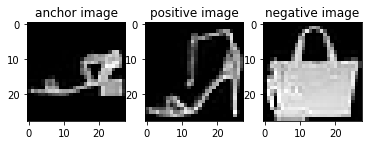

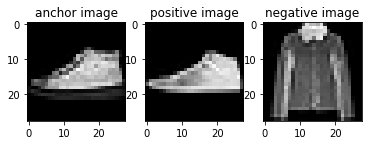

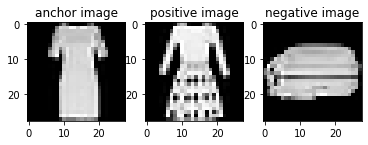

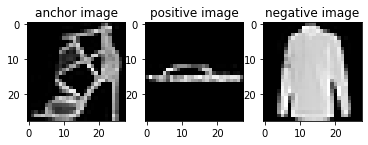

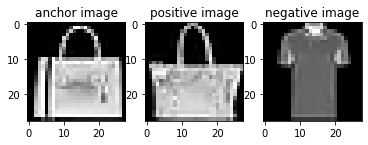

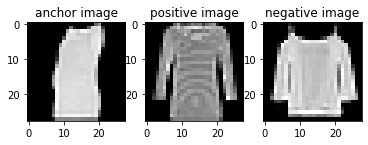

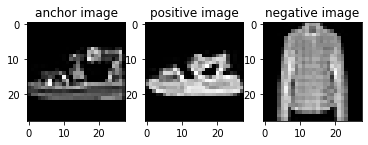

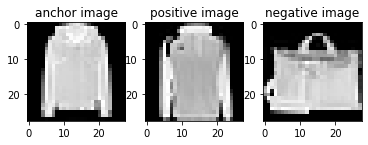

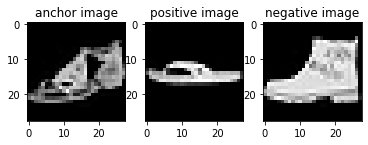

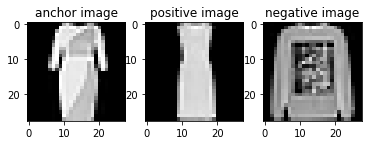

In [31]:
ind = 0
for i in range(len(batch_images1)):
    plt.subplot(131)
    plt.title("anchor image")
    plt.imshow(batch_images1[i].reshape(28,28),cmap="gray")
    plt.subplot(132)
    plt.title("positive image")
    plt.imshow(batch_images2[i].reshape(28,28),cmap="gray")
    plt.subplot(133)
    plt.title("negative image")
    plt.imshow(batch_images3[i].reshape(28,28),cmap="gray")
    plt.show()


# Training

In [32]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 100
log_interval = 100

In [33]:
epochlosses = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

ss: 0.049506
Train: [25600/60000 (43%)]	Loss: 0.045228
Train: [38400/60000 (64%)]	Loss: 0.049492
Train: [51200/60000 (85%)]	Loss: 0.045867
Epoch: 35/100. Train set: Average loss: 0.0475
Epoch: 35/100. Validation set: Average loss: 0.0935
Train: [0/60000 (0%)]	Loss: 0.025551
Train: [12800/60000 (21%)]	Loss: 0.047846
Train: [25600/60000 (43%)]	Loss: 0.043153
Train: [38400/60000 (64%)]	Loss: 0.042693
Train: [51200/60000 (85%)]	Loss: 0.048327
Epoch: 36/100. Train set: Average loss: 0.0460
Epoch: 36/100. Validation set: Average loss: 0.0934
Train: [0/60000 (0%)]	Loss: 0.027507
Train: [12800/60000 (21%)]	Loss: 0.048549
Train: [25600/60000 (43%)]	Loss: 0.045628
Train: [38400/60000 (64%)]	Loss: 0.049123
Train: [51200/60000 (85%)]	Loss: 0.048511
Epoch: 37/100. Train set: Average loss: 0.0474
Epoch: 37/100. Validation set: Average loss: 0.0934
Train: [0/60000 (0%)]	Loss: 0.048388
Train: [12800/60000 (21%)]	Loss: 0.050220
Train: [25600/60000 (43%)]	Loss: 0.044483
Train: [38400/60000 (64%)]	Loss: 

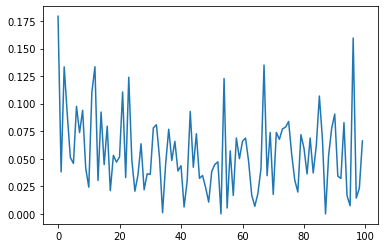

In [34]:
import matplotlib.pyplot as plt 
epochs = []
losses = []
for epoch,loss in epochlosses:
    epochs.append(epoch)
    losses.append(loss[-1])
plt.plot(epochs,losses)
plt.show()


In [35]:
torch.save(model.state_dict(),"triplet_FASHION_MNIST")

In [36]:
model.load_state_dict(torch.load("triplet_FASHION_MNIST"))

<All keys matched successfully>

# Results

In [37]:
with torch.no_grad():
        model.eval()
        difference_coeffs = np.zeros((len(triplet_test_loader.dataset), 2, 2))
        k=0
        for batch_idx, (data,target) in enumerate(triplet_test_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            images0 = data[0].cuda()
            images1 = data[1].cuda()
            images2 = data[2].cuda()
            img0embeddings = model.get_embedding(images0).data.cpu().numpy()
            img1embeddings = model.get_embedding(images1).data.cpu().numpy()
            img2embeddings = model.get_embedding(images2).data.cpu().numpy()
            
            diff = np.array([])
            
            #for every image set in the batch
            for i in range(len(img0embeddings)):
                distance_positive = np.square(img0embeddings[i][0]-img1embeddings[i][0]) + np.square(img0embeddings[i][1]-img1embeddings[i][1])
                distance_negative = np.square(img0embeddings[i][0]-img2embeddings[i][0]) + np.square(img0embeddings[i][1]-img2embeddings[i][1]) 
                dist_tar = np.array([[distance_positive,1],[distance_negative,0]])
                diff = np.append(diff,dist_tar)

            # print(diff.shape)
            diff = np.reshape(diff, (-1, 2, 2))
            difference_coeffs[k:k+len(images0)] = diff
            k += len(images0)

10000


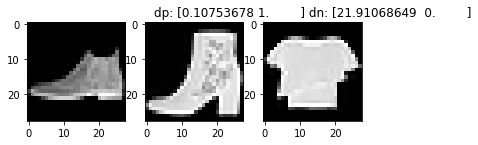

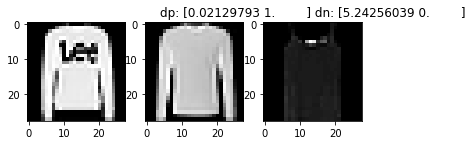

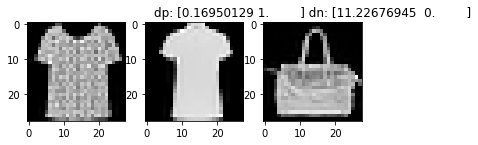

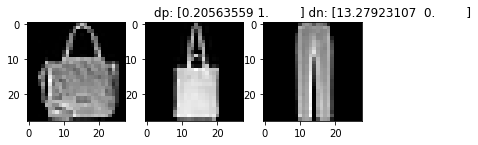

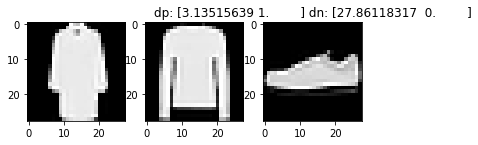

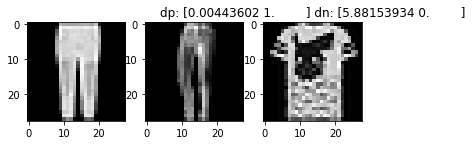

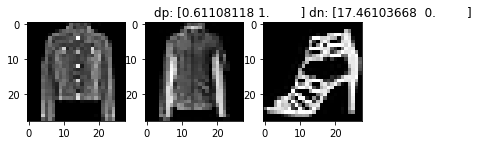

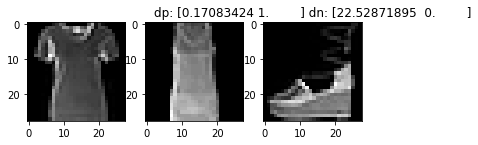

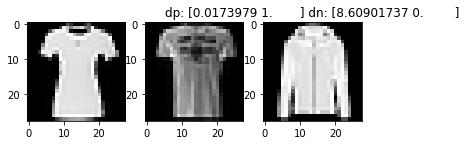

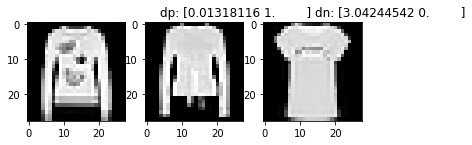

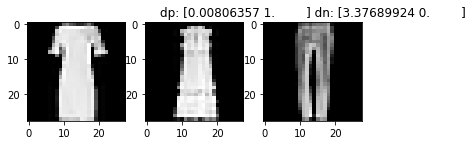

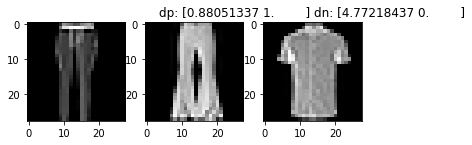

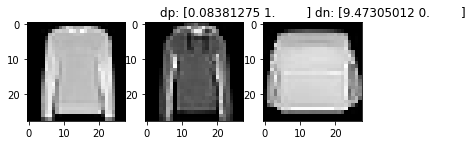

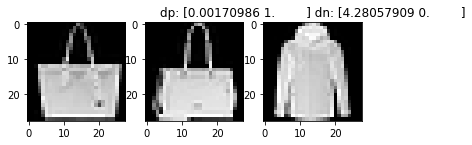

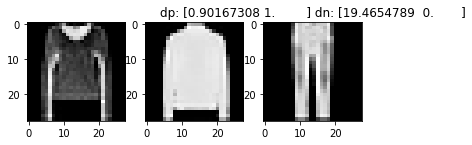

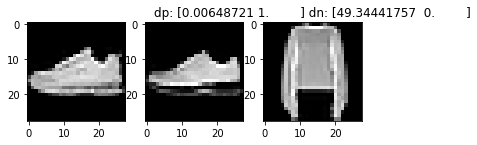

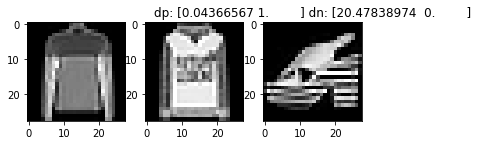

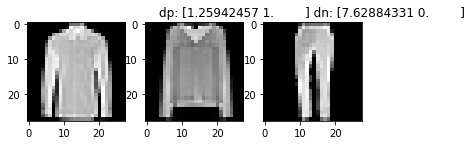

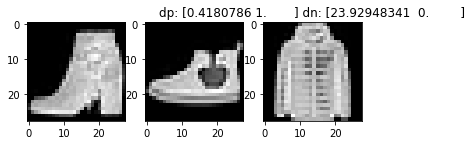

In [38]:
print(len(difference_coeffs))
for i in range(2):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")

for i in range(1000,1001):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(2000,2002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(3000,3002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(4000,4002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(5000,5002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(6000,6002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(7000,7002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(8000,8002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(9000,9002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")

# Visualize Predictions
Based on our results, we can set thresolds as 
positive distance = 0.5 
negative distance = 1
similar images will have the siamese distance < 0.5 and different ones will give a greater distance i.e > 1

In [39]:
threshold_positive = 0.5
threshold_negative = 1

In [40]:
# print(difference_coeffs.shape)
predictions = np.array([])
targets = np.array([])
for x in difference_coeffs:
    #positive
    targets = np.append(targets,1)
    if(x[0][0] <= threshold_positive ):
        predictions = np.append(predictions,1)
    else:
        predictions = np.append(predictions,0)
    #negative
    targets = np.append(targets,0)
    if(x[0][1] >= threshold_positive ):
        predictions = np.append(predictions,0)
    else:
        predictions = np.append(predictions,1)

        
accuracy = len(predictions[predictions == 1])/len(predictions)

In [41]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(targets, predictions)

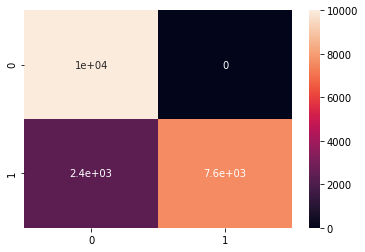

In [42]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [43]:
print(model)

TripletNet(
  (embedding_net): EmbeddingNet(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)
